Exploring several features

In [3]:
from abc import ABC, abstractmethod
import re
from sacremoses import MosesTokenizer
import Levenshtein
import spacy
import nltk
import pickle
import urllib
import os
import tarfile
import zipfile
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
# import paths

import gensim
from string import punctuation
import matplotlib.pyplot as plt
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stopwords = set(stopwords.words("dutch"))
from nltk import word_tokenize
RESOURCES_DIR = Path('../resources')
DATASETS_PATH = RESOURCES_DIR / "datasets"
WORD_EMBEDDINGS_NAME = 'conllmodel' # 'coosto_model' 
DUMPS_DIR = RESOURCES_DIR / "DUMPS"



In [4]:
# http://vectors.nlpl.eu/repository/# # conll dataset
# https://fasttext.cc/docs/en/crawl-vectors.html
# https://github.com/coosto/dutch-word-embeddings


# Current model is CONLL17 model - best results so far. 

In [5]:
def ControlDivisionByZero(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0


class FeatureAbstract(ABC):

    @abstractmethod
    def get_ratio(self, kwargs):
        pass

    @abstractmethod
    def calculate_ratio(self, simple_text, original_text):
        pass


class Feature(FeatureAbstract):

    def __init__(self, split, target_ratio):
        self.split = split
        self.target_ratio = target_ratio

    def get_ratio(self, kwargs):
        if not 'original_text_preprocessed' in kwargs:
            kwargs['original_text_preprocessed'] = ""

        if self.split == "train":
            simple_text = kwargs.get('simple_text')
            original_text = kwargs.get('original_text')
            result_ratio = self.calculate_ratio(simple_text, original_text)

        elif self.split == "valid" or self.split == "test":
            result_ratio = self.target_ratio
        else:
            raise ValueError("stage value not supported")
        kwargs['original_text_preprocessed'] += f'{self.name}_{result_ratio} '
        return kwargs

    @property
    def name(self):
        class_name = self.__class__.__name__
        name = ""
        for word in re.findall('[A-Z][^A-Z]*', class_name):
            if word: name += word[0]
        if not name: name = class_name
        return name


class WordLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            # THIS IS A WORD TOKENIZER, we need one for dutch
            # nl_core_news_sm spacy  spacy.nl_core_news_sm 
            # nltk.word_tokenize
            self.tokenizer =  MosesTokenizer(lang='nl') #  nltk.word_tokenize(language='dutch')  # Moses Tokenizer for Dutch language

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(
            len(self.tokenizer.tokenize(simple_text)),
            len(self.tokenizer.tokenize(original_text))), 2)


class CharLengthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        return round(ControlDivisionByZero(len(simple_text),
            len(original_text)), 2)


class LevenshteinRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)

    def calculate_ratio(self, simple_text, original_text):
        simple_text = word_tokenize(simple_text,language='dutch')
        original_text = word_tokenize(original_text,language='dutch')
        return round(Levenshtein.seqratio(original_text,
                                       simple_text),2)


class DependencyTreeDepthRatio(Feature):

    def __init__(self, stage, target_ratio):
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.nlp = self.get_spacy_model()

    def get_spacy_model(self):

        model = 'nl_core_news_sm'  # from spacy, Dutch pipeline optimized for CPU. Components: tok2vec, morphologizer, tagger, parser, lemmatizer (trainable_lemmatizer), senter, ner.
        if not spacy.util.is_package(model):
            spacy.cli.download(model)
            spacy.cli.link(model, model, force=True, model_path=spacy.util.get_package_path(model))
        return spacy.load(model)

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(ControlDivisionByZero(
            self.get_dependency_tree_depth(simple_text),
            self.get_dependency_tree_depth(original_text)), 2)
        print('type of score', type(result_ratio))
        return result_ratio

    def get_dependency_tree_depth(self, sentence):

        def get_subtree_depth(node):
            if len(list(node.children)) == 0:
                return 0
            return 1 + max([get_subtree_depth(child) for child in node.children])

        tree_depths = [get_subtree_depth(spacy_sentence.root) for spacy_sentence in self.nlp(sentence).sents]
        if len(tree_depths) == 0:
            return 0
        print('type of tree depths', type(tree_depths))
        print(max(tree_depths))
        print(type(max(tree_depths)))
        return max(tree_depths)


class WordRankRatio(Feature):
    # single underscore = internally

    def __init__(self, stage, target_ratio): # constructor of the class 
        super().__init__(stage, target_ratio)
        if stage == "train":
            self.tokenizer = MosesTokenizer(lang='nl')
            self.word2rank = self._get_word2rank()
            print('finished get word2rank')
            print('length of word2rank', len(self.word2rank))
            self.length_rank = len(self.word2rank) # hier length of the file! 

    def calculate_ratio(self, simple_text, original_text):

        result_ratio = round(min(ControlDivisionByZero(self.get_lexical_complexity_score(simple_text),
                                                       self.get_lexical_complexity_score(original_text)),
                                 2), 2)

        return result_ratio

    def get_lexical_complexity_score(self, sentence, quantile_value=0.75):

        words = self.tokenizer.tokenize(self._remove_stopwords(self._remove_punctuation(sentence)))
        words = [word for word in words if word in self.word2rank]
        if len(words) == 0:
            return np.log(1 + self.length_rank)
        return np.quantile([self._get_rank(word) for word in words], quantile_value)

    def _remove_punctuation(self, text):
        return ' '.join([word for word in self.tokenizer.tokenize(text) if not self._is_punctuation(word)])

    def _remove_stopwords(self, text):
        return ' '.join([w for w in self.tokenizer.tokenize(text) if w.lower() not in stopwords])

    def _is_punctuation(self, word):
        return ''.join([char for char in word if char not in punctuation]) == ''

    def _get_rank(self, word):
        rank = self.word2rank.get(word, self.length_rank)
        return np.log(1 + rank)

    def _get_word2rank(self, vocab_size=np.inf):
        model_filepath = DUMPS_DIR / f"{WORD_EMBEDDINGS_NAME}.pk"
        if model_filepath.exists():
            with open(model_filepath, 'rb') as f:
                model = pickle.load(f)
            return model
        else:
            print("Processing", f"{WORD_EMBEDDINGS_NAME}...")
            print("Preprocessing word2rank...")
            DUMPS_DIR.mkdir(parents=True, exist_ok=True)
            WORD_EMBEDDINGS_PATH = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            lines_generator = self._yield_lines(WORD_EMBEDDINGS_PATH)
            word2rank = {}
            # next(lines_generator)
            for i, line in enumerate(lines_generator):
                if i >= vocab_size: break
                word = line.split(' ')[0]
                word2rank[word] = i

            pickle.dump(word2rank, open(model_filepath, 'wb'))
            # txt_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
            # zip_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.zip'
            # if txt_file.exists(): txt_file.unlink()
            # if zip_file.exists(): zip_file.unlink()
            return word2rank
        
        # else:            
        #     print("Downloading dutch embeddings ...") # pretrained vectors
        #     self._download_embeddings(model_name='coostco', dest_dir=str(DUMPS_DIR))
        #     print("Preprocessing word2rank...")
        #     DUMPS_DIR.mkdir(parents=True, exist_ok=True)
        #     WORD_EMBEDDINGS_PATH = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.bin'
        #     model = self._load_word_embeddings(WORD_EMBEDDINGS_PATH) # returns index_to_key
        #     # store into file
        #     lines_generator = model # self._yield_lines(model) # (WORD_EMBEDDINGS_PATH)
            
        #     word2rank = {}
        #     # next(lines_generator)
        #     print('vocab_size', vocab_size)
        #     for i, line in enumerate(lines_generator):
        #         if i >= vocab_size: break # its not vocab size any more but  # len(model.key_to_index)
        #         word = line.split(',')[0]
        #         print('word', word)
        #         word2rank[word] = i
        #         print('ranked word?', word2rank[word])
                
        #     pickle.dump(word2rank, open(model_filepath, 'wb'))
        #     txt_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.txt'
        #     zip_file = DUMPS_DIR / f'{WORD_EMBEDDINGS_NAME}.zip'
        #     # if txt_file.exists(): txt_file.unlink()
        #     # if zip_file.exists(): zip_file.unlink()
        #     # print(word2rank)
        #     return word2rank
    
    def _load_word_embeddings(self, filepath):
        model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True) # '../resources/DUMPS/model.bin'
        model_indexes = model.index_to_key
        return model_indexes

    def _download_embeddings(self, model_name, dest_dir): # pretrained rankings
        url = ''
        if model_name == 'coost0_model':
            url = 'https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin'

        file_path = self._download_url(url, dest_dir)
        out_filepath = Path(file_path)
        out_filepath = out_filepath.parent / f'{out_filepath.stem}.txt'
        # print(out_filepath, out_filepath.exists())
        if not out_filepath.exists():
            print("Extracting: ", Path(file_path).name)
            self._unzip(file_path, dest_dir)

    def _yield_lines(self, filepath):
        filepath = Path(filepath)
        with filepath.open('r', encoding="latin-1") as f:
            for line in f:
                print(line)
                yield line.rstrip()

    def _download_url(self, url, output_path):
        name = url.split('/')[-1]
        file_path = f'{output_path}/{name}'
        if not Path(file_path).exists():
            with tqdm(unit='B', unit_scale=True, leave=True, miniters=1,
                      desc=name) as t:  # all optional kwargs
                urllib.request.urlretrieve(url, filename=file_path, reporthook=self._download_report_hook(t), data=None)
        return file_path

    def _unzip(self, file_path, dest_dir=None):
        if dest_dir is None:
            dest_dir = os.path.dirname(file_path)
        if file_path.endswith('.zip'):
            with zipfile.ZipFile(file_path, "r") as zip_ref:
                zip_ref.extractall(dest_dir)
        elif file_path.endswith("tar.gz") or file_path.endswith("tgz"):
            tar = tarfile.open(file_path, "r:gz")
            tar.extractall(dest_dir)
            tar.close()
        elif file_path.endswith("tar"):
            tar = tarfile.open(file_path, "r:")
            tar.extractall(dest_dir)
            tar.close()

    def _download_report_hook(self, t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

In [6]:
# sentences_pair = {"original_text": "Er is manuscriptbewijs dat Austen tot in de periode 1809-11 aan deze stukken bleef werken, en dat haar nicht en neef, Anna en James Edward Austen, tot in 1814 verdere toevoegingen maakten.", "simple_text": "Er zijn aanwijzingen dat Austen later in zijn leven aan deze stukken bleef werken. Haar neef en nicht, James Edward en Anna Austen, hebben rond 1814 mogelijk nog meer aan haar werk toegevoegd."}


sentences_pair = {"simple_text": "Een signaaltransductie in de biologie is een cellulair mechanisme.", 
"original_text": "Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde."}

In [7]:
word_rank = WordRankRatio("train", 0.8)
sentences_pair = word_rank.get_ratio(sentences_pair)
sentences_pair

finished get word2rank
length of word2rank 2610659


{'simple_text': 'Een signaaltransductie in de biologie is een cellulair mechanisme.',
 'original_text': 'Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde.',
 'original_text_preprocessed': 'WRR_0.93 '}

In [8]:
char = CharLengthRatio("train", 0.8)
sentences_pair = char.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Een signaaltransductie in de biologie is een cellulair mechanisme.',
 'original_text': 'Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde.',
 'original_text_preprocessed': 'WRR_0.93 CLR_0.41 '}

In [9]:
word_length = WordLengthRatio("train", 0.8)
sentences_pair = word_length.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Een signaaltransductie in de biologie is een cellulair mechanisme.',
 'original_text': 'Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde.',
 'original_text_preprocessed': 'WRR_0.93 CLR_0.41 WLR_0.48 '}

In [10]:
levenshtein = LevenshteinRatio("train", 0.8)
sentences_pair = levenshtein.get_ratio(sentences_pair)
sentences_pair

{'simple_text': 'Een signaaltransductie in de biologie is een cellulair mechanisme.',
 'original_text': 'Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde.',
 'original_text_preprocessed': 'WRR_0.93 CLR_0.41 WLR_0.48 LR_0.25 '}

In [11]:
dependency = DependencyTreeDepthRatio("train", 0.8)
sentences_pair = dependency.get_ratio(sentences_pair)
sentences_pair

type of tree depths <class 'list'>
3
<class 'int'>
type of tree depths <class 'list'>
4
<class 'int'>
type of score <class 'float'>


{'simple_text': 'Een signaaltransductie in de biologie is een cellulair mechanisme.',
 'original_text': 'Veel ziekteprocessen, zoals diabetes, hartaandoeningen, auto-immuniteit en kanker, ontstaan door signaaltransductieroutes, wat het signaaltransductie geneeskunde.',
 'original_text_preprocessed': 'WRR_0.93 CLR_0.41 WLR_0.48 LR_0.25 DTDR_0.75 '}

Exploring features values from simpleText shared task

In [12]:
WIKILARGE_DATASET_PATH = DATASETS_PATH / "wikilarge"

In [13]:
complex_text = pd.read_csv(WIKILARGE_DATASET_PATH / "wikilarge.train.orig", header=None, sep="\t", names=["original_text"])
simple_text = pd.read_csv(WIKILARGE_DATASET_PATH / "wikilarge.train.simp", header=None, sep="\t",names=["simple_text"])

In [14]:
sentences_pairs = pd.concat([complex_text, simple_text], axis=1)
sentences_pairs=sentences_pairs[0:19]

In [15]:
results = []
for i,row in sentences_pairs.iterrows():
    print(sentences_pairs)
    sentences_pair = dict(original_text=row['original_text'], simple_text=row['simple_text'])
    sentences_pair = char.get_ratio(sentences_pair)
    sentences_pair = word_length.get_ratio(sentences_pair)
    sentences_pair = levenshtein.get_ratio(sentences_pair)
    sentences_pair = dependency.get_ratio(sentences_pair)
    sentences_pair = word_rank.get_ratio(sentences_pair)
    features = sentences_pair["original_text_preprocessed"].strip().split(" ")
    instance = dict(feature.split("_") for feature in features)
    results.append(instance)

                                        original_text  \
0   Er is manuscriptbewijs dat Austen tot in de pe...   
1   In een opmerkelijke vergelijkende analyse toon...   
2   Voordat Persephone werd vrijgelaten aan Hermes...   
3   Warmtekrachtkoppelingsinstallaties worden vaak...   
4   Genève ( , ; , ; , ; ; ) is de tweede meest be...   
5   Toen Japan tien jaar later weer een race verdi...   
6   Dit was het eerste motorrace-evenement in de f...   
7   Ka La Ku'oko'a (Hawaïaanse onafhankelijkheidsd...   
8   Een zeis (Oxford English Dictionary, Oxford Un...   
9   Toshihide Saito is een Japanse voetbalverdediger.   
10  Velen verwijzen nog steeds naar 25, 50 en 75 p...   
11  In Holland werden ze Stadspijpers genoemd, in ...   
12  Toneelstukken en komisch poppentheater die los...   
13  Geregisseerd door Jon Avnet en geschreven door...   
14  Beaumont-Pied-de-B Å'uf is een gemeente in het...   
15  In september 1869 ontsnapte O'Reilly en werd g...   
16  De Algerijnse regering snee

In [16]:
len(results)
results_df = pd.DataFrame(results).astype('float')

In [17]:
results_df

,CLR,WLR,LR,DTDR,WRR
0,1.02,1.03,0.57,0.83,0.93
1,0.73,0.79,0.83,1.00,1.02
2,0.98,1.00,0.45,0.67,1.01
3,1.02,1.03,0.98,1.00,0.96
4,1.01,0.84,0.28,0.75,1.13
5,0.98,0.95,0.89,1.00,0.94
6,1.00,1.00,1.00,1.00,1.00
7,0.82,0.84,0.73,0.75,0.91
8,0.33,0.33,0.27,0.50,1.01
9,1.35,1.86,0.57,1.50,0.55


Summary statistics

In [18]:
results_df.describe()

,CLR,WLR,LR,DTDR,WRR
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.835263,0.876842,0.603158,0.825263,1.019474
std,0.370935,0.460737,0.269919,0.321202,0.228290
min,0.130000,0.080000,0.140000,0.000000,0.550000
25%,0.685000,0.705000,0.425000,0.710000,0.935000
50%,0.920000,0.930000,0.600000,1.000000,1.000000
75%,1.005000,1.000000,0.805000,1.000000,1.015000
max,1.650000,1.940000,1.000000,1.500000,1.780000


Character Length Ratio

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\77662681.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["CLR"])


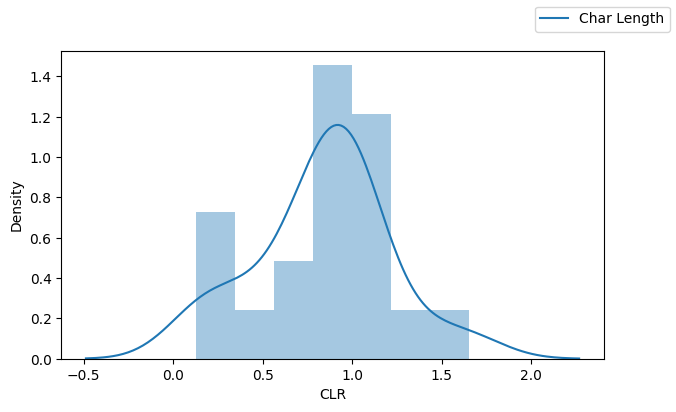

In [19]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["CLR"])
fig.legend(labels=['Char Length'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\2024043087.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["WLR"],label="Word Length")


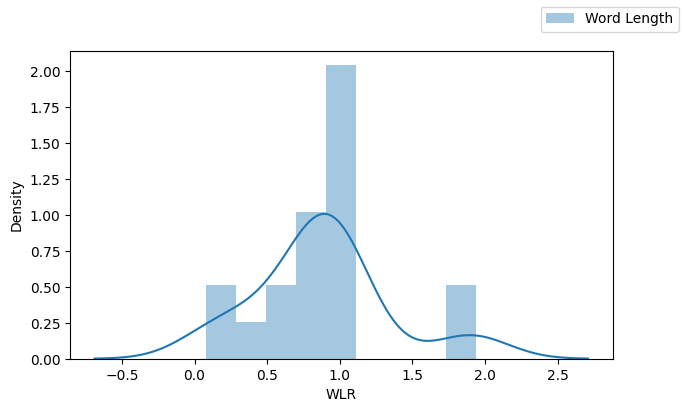

In [20]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["WLR"],label="Word Length")
fig.legend(labels=['Word Length'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\80846115.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["LR"])


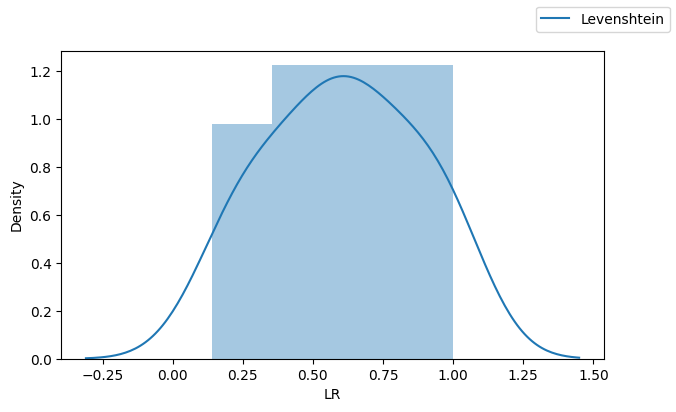

In [21]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["LR"])
fig.legend(labels=['Levenshtein'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\80846115.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["LR"])


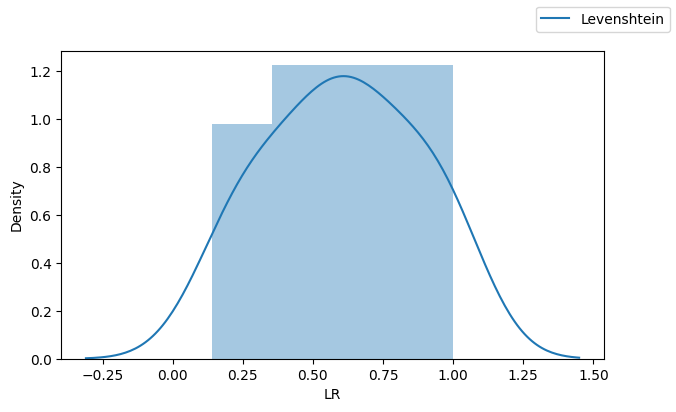

In [22]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["LR"])
fig.legend(labels=['Levenshtein'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\1042114587.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["DTDR"])


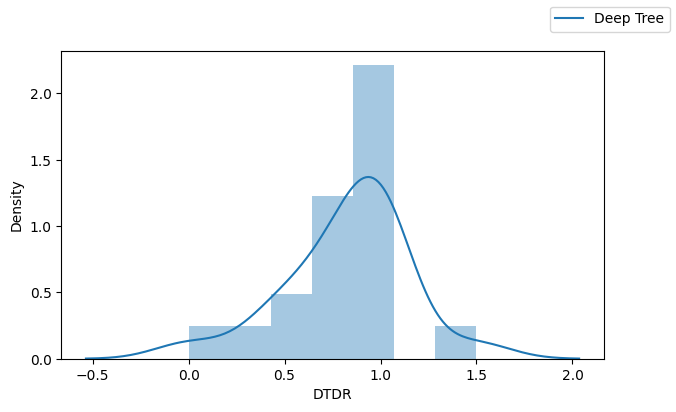

In [23]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["DTDR"])
fig.legend(labels=['Deep Tree'])
plt.show()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_5340\3959122587.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df["WRR"])


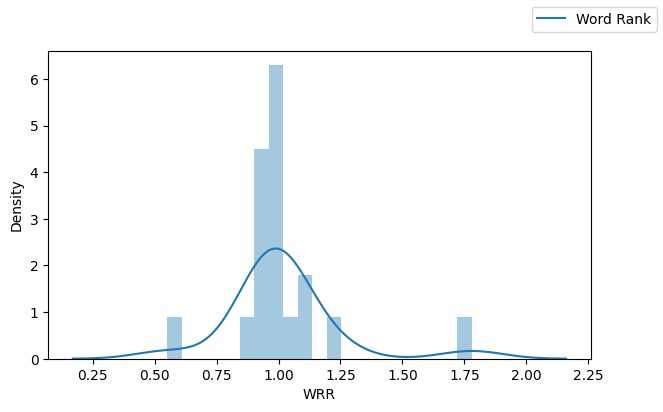

In [24]:
fig = plt.figure(figsize=(7,4))
sns.distplot(results_df["WRR"])
fig.legend(labels=['Word Rank'])
plt.show()